<a href="https://colab.research.google.com/github/abuqaiselegant/internitytask001/blob/main/log_analysis_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import requests
import urllib.request
import json
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [2]:
def html_to_df(urls, clean_empty = False , attrs = {}, helper = None):
    df_l = []
    for url in urls:
        html_content = requests.get(url).text
        soup = bs(html_content, "lxml")
        table = str(soup.find("table", attrs=attrs))
        df = pd.read_html(str(table))[0]
    
        if clean_empty :
            df = df.loc[:, ~df.isnull().all(axis = 0)]
        
        if helper:
            df = helper(df) 
        df_l.append(df)
    return pd.concat(df_l,ignore_index=True)

In [3]:
url_1 = "https://github.com/ayedaemon/RuckSack-Python/blob/master/log_analysis/access_log"
url_2 = "https://github.com/ayedaemon/RuckSack-Python/blob/master/log_analysis/access_log2"
url_3 = "https://github.com/robert456456456456/Web_server_log_parser/blob/master/devops.log"
urls=[url_1,url_2,url_3]

In [4]:
def log_df(df,col_name ,columns = [] ):
    '''
    input: 
        df : dataframe
        col_name : column name of dataframe on which we need to apply function.
        columns : column name for new dataframe.
    output:
        return new dataframe.
    '''
    def log_parser(str_):
        '''
        input:
            str_ : log string.
        output:
            return a dictionary which contain all element of log string.
        '''
        find = {}
        find['ip'] = str_.split()[0]
        find['RFC931'] = str_.split()[1]
        find['user'] = str_.split()[2]
        find['date'] = str_.split('[')[1].split()[0]
        find['gmt'] = str_.split('[')[1].split()[1].strip(']')
        try:
            if 'HTTP' in str_.split('"')[1].split()[-1]:
                find['action'] =  str_.split('"')[1].replace(str_.split('"')[1].split()[2],'').strip()
            else:
                find['action'] =  str_.split('"')[1].strip()
        except:
            find['action'] = '-'
        try:
            find['status'] = str_.split('"')[2].strip().split()[0]
        except:
            find['status'] = '-'
        try:
            find['size'] = str_.split('"')[2].strip().split()[1]
        except:
            find['size'] = '-'
        try:
            find['referrer'] = str_.strip().split('"')[3]
        except:
            find['referrer'] ='-'
        try:
            find['browser'] = str_.strip().split('"')[5]
        except:
            find['browser'] = '-'
        
        return find


    df = pd.DataFrame(list(df[col_name].apply(log_parser).values) )
    if len(df.columns) == len(columns):
        df.columns = columns
    return df

In [5]:
def XSS_finder(str_):
    flag = 0
    l1 = ['<','>','\\','`']
    l2 = ['/',')','(']
    for char in l1:
        aasci_encoding = '%'+hex(ord(char)).replace('0x','')
        if (char in str_) or (aasci_encoding in str_):
            flag = 1
            break
    if flag != 1:
        try:
            req_str = ''.join(str_.split('?')[1:])
            for char in l2:
                aasci_encoding = '%'+hex(ord(char)).replace('0x','')
                if (char in req_str) or (aasci_encoding in req_str):
                    flag = 1
                    break
        except:
            pass
    return bool(flag)
    
def add_location_data(df,column,keys):
    def loc_dict_maker(unq_series):
        '''
        input:
            series: series of unique ip address.
        output:
            res: dict contain country code, lat, long.
        '''
        def ip_loc(x):
            '''
            input:
                x : ip address
            output:
                dictionary which contain country,latitude and longitude.
            '''
            res = {}
            url = "https://geolocation-db.com/jsonp/"+x
            with urllib.request.urlopen(url) as url:
                data = json.loads(url.read().decode().split("(")[1].strip(")"))
            res = {"country_code":data["country_code"], 'latitude':data['latitude'],'longitude':data['longitude']}
            try:
                res['alpha_3'] = pycountry.countries.get(alpha_2=res["country_code"]).alpha_3
            except:
                res['alpha_3'] = 'Not found'
            return res

        result = {}
        for ip in tqdm(unq_series):
            result[ip] = ip_loc(ip)
        return result
    
    loc_dict = loc_dict_maker(df[column].unique())
    for key in keys:
        df[key] = df[column].apply(lambda x: loc_dict[x][key])
    return df

In [6]:
df = html_to_df(urls,clean_empty=True)

In [7]:
df

,1
0,"127.0.0.1 - - [15/Jan/2021:08:54:07 +0000] ""GE..."
1,"127.0.0.1 - - [15/Jan/2021:08:55:23 +0000] ""GE..."
2,"127.0.0.1 - - [15/Jan/2021:09:01:38 +0000] ""GE..."
3,"172.17.0.1 - - [15/Jan/2021:09:02:14 +0000] ""G..."
4,"172.17.0.1 - - [15/Jan/2021:09:02:15 +0000] ""G..."
...,...
3341,"10.0.0.153 - - [12/Mar/2004:12:23:41 -0800] ""G..."
3342,"10.0.0.153 - - [12/Mar/2004:12:23:41 -0800] ""G..."
3343,216.139.185.45 - - [12/Mar/2004:13:04:01 -0800...
3344,pd95f99f2.dip.t-dialin.net - - [12/Mar/2004:13...


In [8]:
columns = ["User Address","RFC931","User","date/time","gmt","action","status","size","referrer","browser"]
df = log_df(df,1,columns)

In [9]:
df

,User Address,RFC931,User,date/time,gmt,action,status,size,referrer,browser
0,127.0.0.1,-,-,15/Jan/2021:08:54:07,+0000,GET /,403,4006,-,curl/7.61.1
1,127.0.0.1,-,-,15/Jan/2021:08:55:23,+0000,GET /cgi-bin/weakform.py,403,199,-,curl/7.61.1
2,127.0.0.1,-,-,15/Jan/2021:09:01:38,+0000,GET /cgi-bin/weak_form.py,200,19,-,curl/7.61.1
3,172.17.0.1,-,-,15/Jan/2021:09:02:14,+0000,GET /,403,4288,-,Mozilla/5.0 (X11; Linux x86_64; rv:84.0) Gecko...
4,172.17.0.1,-,-,15/Jan/2021:09:02:15,+0000,GET /noindex/common/css/bootstrap.min.css,200,99548,http://172.17.0.2/,Mozilla/5.0 (X11; Linux x86_64; rv:84.0) Gecko...
...,...,...,...,...,...,...,...,...,...,...
3341,10.0.0.153,-,-,12/Mar/2004:12:23:41,-0800,GET /dccstats/stats-spam-ratio.1year.png,200,1906,-,-
3342,10.0.0.153,-,-,12/Mar/2004:12:23:41,-0800,GET /dccstats/stats-hashes.1year.png,200,1582,-,-
3343,216.139.185.45,-,-,12/Mar/2004:13:04:01,-0800,GET /mailman/listinfo/webber,200,6051,-,-
3344,pd95f99f2.dip.t-dialin.net,-,-,12/Mar/2004:13:18:57,-0800,GET /razor.html,200,2869,-,-


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3346 entries, 0 to 3345
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   User Address  3346 non-null   object
 1   RFC931        3346 non-null   object
 2   User          3346 non-null   object
 3   date/time     3346 non-null   object
 4   gmt           3346 non-null   object
 5   action        3346 non-null   object
 6   status        3346 non-null   object
 7   size          3346 non-null   object
 8   referrer      3346 non-null   object
 9   browser       3346 non-null   object
dtypes: object(10)
memory usage: 261.5+ KB


In [11]:
df['date/time']=pd.to_datetime(df['date/time'], format='%d/%b/%Y:%H:%M:%S')
df['date'] = df['date/time'].dt.date
df['time'] = df['date/time'].dt.time

In [12]:
df['XSS_attack'] = df['action'].apply(XSS_finder)

In [13]:
df.XSS_attack.unique()

array([False,  True])

In [14]:
df[df.XSS_attack == True]

,User Address,RFC931,User,date/time,gmt,action,status,size,referrer,browser,date,time,XSS_attack
754,172.17.0.1,-,-,2021-01-15 10:05:35,+0000,GET /cgi-bin/weak_form.py?fname=asdasd%3C%2Fp%...,200,355,http://172.17.0.2/cgi-bin/weak_form.py?fname=s...,Mozilla/5.0 (X11; Linux x86_64; rv:84.0) Gecko...,2021-01-15,10:05:35,True
757,172.17.0.1,-,-,2021-01-16 05:29:02,+0000,GET /cgi-bin/weak_form.py?fname=abcd&lname=111...,200,328,-,curl/7.74.0,2021-01-16,05:29:02,True
758,172.17.0.1,-,-,2021-01-16 05:30:04,+0000,GET /cgi-bin/weak_form.py?fname=abcd&lname=111...,200,340,-,curl/7.74.0,2021-01-16,05:30:04,True
759,172.17.0.1,-,-,2021-01-16 05:30:42,+0000,GET /cgi-bin/weak_form.py?fname=abcd&lname=111...,200,340,-,curl/7.74.0,2021-01-16,05:30:42,True
760,172.17.0.1,-,-,2021-01-16 05:30:57,+0000,GET /cgi-bin/weak_form.py?fname=abcd&lname=111...,200,341,-,curl/7.74.0,2021-01-16,05:30:57,True
761,172.17.0.1,-,-,2021-01-16 05:31:04,+0000,GET /cgi-bin/weak_form.py?fname=abcd&lname=111...,200,357,-,curl/7.74.0,2021-01-16,05:31:04,True
762,172.17.0.1,-,-,2021-01-16 05:31:24,+0000,GET /cgi-bin/weak_form.py?fname=abcd&lname=111...,200,357,-,curl/7.74.0,2021-01-16,05:31:24,True
763,172.17.0.1,-,-,2021-01-16 05:31:28,+0000,GET /cgi-bin/weak_form.py?fname=abcd&lname=111...,200,340,-,curl/7.74.0,2021-01-16,05:31:28,True
764,172.17.0.1,-,-,2021-01-16 05:31:34,+0000,GET /cgi-bin/weak_form.py?fname=abcd&lname=111...,200,357,-,curl/7.74.0,2021-01-16,05:31:34,True
765,172.17.0.1,-,-,2021-01-16 05:32:02,+0000,GET /cgi-bin/weak_form.py?fname=abcd&lname=111...,200,357,-,curl/7.74.0,2021-01-16,05:32:02,True


In [94]:
fig=px.line(df,x=df.date.unique(),y=df.date.value_counts(),title="HITS")
fig.update_xaxes(rangeslider_visible=True,
                 rangeselector=dict(
                     buttons=list([
                                   dict(count=1, label="1m", step="month", stepmode="backward"),
                                   dict(count=6, label="6m", step="month", stepmode="backward"),
                                   dict(count=1, label="YTD", step="year", stepmode="todate"),
                                   dict(count=1, label="1y", step="year", stepmode="backward"),
                                   dict(step="all")
                                   ])
                 )
)
fig.show()

In [97]:
fig=px.line(df,x=df[df.XSS_attack==True].date.unique(),y=df[df.XSS_attack==True].date.value_counts(),title="XSS attack True during 2004 to 2021")
fig.update_xaxes(rangeslider_visible=True,
                 rangeselector=dict(
                     buttons=list([
                                   dict(count=1, label="1m", step="month", stepmode="backward"),
                                   dict(count=6, label="6m", step="month", stepmode="backward"),
                                   dict(count=1, label="YTD", step="year", stepmode="todate"),
                                   dict(count=1, label="1y", step="year", stepmode="backward"),
                                   dict(step="all")
                                   ])
                 )
)
fig.show()

In [98]:
fig=px.line(df,x=df[df.XSS_attack==False].date.unique(),y=df[df.XSS_attack==False].date.value_counts(),title="False XSS attack during 2004 to 2021")
fig.update_xaxes(rangeslider_visible=True,
                 rangeselector=dict(
                     buttons=list([
                                   dict(count=1, label="1m", step="month", stepmode="backward"),
                                   dict(count=6, label="6m", step="month", stepmode="backward"),
                                   dict(count=1, label="YTD", step="year", stepmode="todate"),
                                   dict(count=1, label="1y", step="year", stepmode="backward"),
                                   dict(step="all")
                                   ])
                 )
)
fig.show()

**OS and thier Browser**

In [39]:

def OS_dict(browser_series):
    os = ['Windows','Unix','Linux','Other']
    res_dict = {o:0 for o in os}
    for browser in browser_series:
        flag = 0
        for i in os[:-1]:
            if i in browser:
                res_dict[i]+=1
                flag = 1
                break
        if flag==0:
            res_dict['Other']+=1
    return res_dict

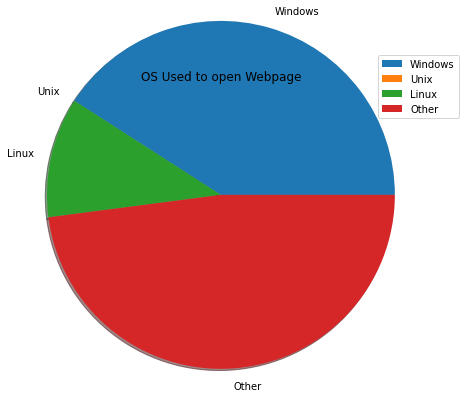

In [63]:
OS = OS_dict(df.browser)
plt.pie( list(OS.values()), labels=list(OS.keys()),startangle=0,radius=2,shadow=True)
plt.title("OS Used to open Webpage")
plt.legend(loc='center left', bbox_to_anchor=(1.2, 1))
plt.show()

In [21]:

def brwsr_dict(browser_series):
    brwsr = ['Firefox','Chrome','Opera','IE','Safari','Other']
    res_dict = {o:0 for o in brwsr}
    for browser in browser_series:
        flag = 0
        for i in brwsr[:-1]:
            if i in browser:
                res_dict[i]+=1
                flag = 1
                break
        if flag==0:
            res_dict['Other']+=1
    return res_dict

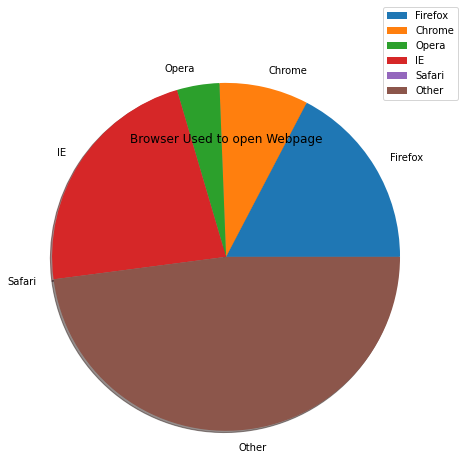

In [68]:
BRWSR = brwsr_dict(df.browser)
plt.pie( list(BRWSR.values()), labels=list(BRWSR.keys()),startangle=0,radius=2,shadow=True)
plt.title('Browser Used to open Webpage')
plt.legend(loc='best', bbox_to_anchor=(1.2, 1.2))
plt.show()

**Most and least visited User**

In [89]:

def most_and_least_visited_user(df):
    result = {}   # making a dictionary as key are "most visted user " and .... list only take indices as int
    result['most_visited_user'] = df['User Address'].value_counts().head(1).index
    result['least_visited_user'] = df['User Address'].value_counts().tail(1).index
    result = pd.DataFrame.from_dict(result,orient='index')
    return result


In [91]:
most_and_least_visited_user(df)

,0
most_visited_user,172.17.0.1
least_visited_user,206-15-133-153.dialup.ziplink.net


In [87]:
def most_and_least_visited_page(df):
    result = {}
    pages = df.action.apply(lambda x: x.split('?')[0])
    result['Top_visited_page'] = list(pages.value_counts().head(1).index)
    result['least_visited_page'] = list(pages.value_counts().tail(1).index)
    result = pd.DataFrame.from_dict(result,orient='index')
    return result

In [88]:
most_and_least_visited_page(df)

,0
Top_visited_page,GET /cgi-bin/weak_form.py
least_visited_page,GET /twiki/bin/rdiff/TWiki/PeterFokkinga
